# **ERA5 MONTHLY PRECIPITATION DATA ( CALCULATING ANOMALIES AND PRECIPITATION VALUES )**




---


For more datasets:

https://developers.google.com/earth-engine/datasets/tags/climate


---




# **Installing GEE, importing required libraries, authentication, base map**

In [1]:
# Installs geemap

import subprocess
try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

In [2]:
import ee
import geemap
import pandas as pd # library to manage DataFrames
import matplotlib.pyplot as plt # library to manage Graphs

In [3]:
# Iniciates sesion

ee.Authenticate()
ee.Initialize(project='ee-alexorri')

In [4]:
# Creating Base Map

Map = geemap.Map(center=[-50.498345, -73.120696], zoom=12)

punt = ee.Geometry.Point(-73.120696, -50.498345)
Map.addLayer(punt, {'color': 'red'}, 'Location point')  # shows point on map

# Visualize

Map

Map(center=[-50.498345, -73.120696], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

##**Monthly precipitation anomaly within a reference timerange**


###**Calculating the mean and the standard devaition for the reference timerange**

Reference timerange; considering a minimum of 30 years (1961 to 1990)

In [5]:
# Reference timerange from 1961-1990

start_date_ref = "1961-01-01"
end_date_ref = "1990-12-31"


In [6]:
# Check for bands within the dataset

dataset = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
bandes=dataset.first().bandNames()
bandes.getInfo()

['dewpoint_temperature_2m',
 'temperature_2m',
 'skin_temperature',
 'soil_temperature_level_1',
 'soil_temperature_level_2',
 'soil_temperature_level_3',
 'soil_temperature_level_4',
 'lake_bottom_temperature',
 'lake_ice_depth',
 'lake_ice_temperature',
 'lake_mix_layer_depth',
 'lake_mix_layer_temperature',
 'lake_shape_factor',
 'lake_total_layer_temperature',
 'snow_albedo',
 'snow_cover',
 'snow_density',
 'snow_depth',
 'snow_depth_water_equivalent',
 'snowfall_sum',
 'snowmelt_sum',
 'temperature_of_snow_layer',
 'skin_reservoir_content',
 'volumetric_soil_water_layer_1',
 'volumetric_soil_water_layer_2',
 'volumetric_soil_water_layer_3',
 'volumetric_soil_water_layer_4',
 'forecast_albedo',
 'surface_latent_heat_flux_sum',
 'surface_net_solar_radiation_sum',
 'surface_net_thermal_radiation_sum',
 'surface_sensible_heat_flux_sum',
 'surface_solar_radiation_downwards_sum',
 'surface_thermal_radiation_downwards_sum',
 'evaporation_from_bare_soil_sum',
 'evaporation_from_open_wate

In [7]:
# Defining the band selected on the dataset filtering with point and timerange

dataset_ref = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR")\
  .filterBounds(punt) \
  .filterDate(start_date_ref, end_date_ref) \
  .select("total_precipitation_sum")


In [8]:
# Function that extracts precipitation values for the point and the data
# (year and month). Precipitation values are given in (m); changing that to (mm)

def get_precipitation(img):
    date = img.date().format("YYYY-MM")  # Extrec any-mes
    value = img.sample(punt).first().get('total_precipitation_sum')
    value = ee.Number(value).multiply(1000)

    return ee.Feature(None, {"date": date, "precipitation": value})


In [9]:
# Applying the function to the dataset within reference timerange

precip_features_ref = dataset_ref.map(get_precipitation).getInfo()

# Converting results into a dictionary

data_list_ref = [feat["properties"] for feat in precip_features_ref["features"]]

# Conversion to DataFrame

df_ref = pd.DataFrame(data_list_ref)
display(df_ref)


,date,precipitation
0,1961-01,514.751598
1,1961-02,219.032412
2,1961-03,542.549519
3,1961-04,356.656289
4,1961-05,328.416205
...,...,...
355,1990-08,359.887404
356,1990-09,187.890985
357,1990-10,549.817671
358,1990-11,532.993680


In [10]:
# Converting column "date" into datetime format

df_ref["date"] = pd.to_datetime(df_ref["date"])

# Grouping monthly for calculating the mean and the standard deviation

df_ref["month"] = df_ref["date"].dt.month
df_ref["year"] = df_ref["date"].dt.year

stats = df_ref.groupby("month")["precipitation"].agg(["mean", "std"]).reset_index()

# Showing results

print(stats)

    month        mean         std
0       1  330.545306   90.315616
1       2  273.717255  109.899225
2       3  307.831314   87.401590
3       4  312.148217   89.682100
4       5  263.362178   96.531307
5       6  254.941150  112.718430
6       7  232.442107   82.574383
7       8  263.977311  103.988357
8       9  230.083056   77.906418
9      10  243.810617   94.186108
10     11  295.294803  120.825377
11     12  301.521436   94.766012


##**Calculating monthly precipitation anomaly for a single year**

In [11]:
# Select year to calaculate de anomaly

year = 2022

# Time range for the year selected ( whole year )

start_date_analisis = str(year) + "-01-01"
end_date_analisis = str(year) + "-12-31"



In [12]:
# Dataset to calculate anomaly ( note is the precipitation; change also the 30 year reference if we want to analyse another variable)

dataset_analisis = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR")\
  .filterBounds(punt) \
  .filterDate(start_date_analisis, end_date_analisis) \
  .select("total_precipitation_sum")


In [13]:
# Applying function to calculate de precipitation at point

precip_features_analisis = dataset_analisis.map(get_precipitation).getInfo()

data_list_analisis = [feat["properties"] for feat in precip_features_analisis["features"]]
df_analisis = pd.DataFrame(data_list_analisis)
df_analisis["date"] = pd.to_datetime(df_analisis["date"])
df_analisis["month"] = df_analisis["date"].dt.month


In [14]:
# Calculate the precipitation anomaly

df_merged = pd.merge(df_analisis, stats, on="month", how="left")


df_merged["anomalia"] = (df_merged["precipitation"] - df_merged["mean"]) / df_merged["std"]

# Show results

print(df_merged)


         date  precipitation  month        mean         std  anomalia
0  2022-01-01     267.332226      1  330.545306   90.315616 -0.699913
1  2022-02-01     217.404476      2  273.717255  109.899225 -0.512404
2  2022-03-01     293.606932      3  307.831314   87.401590 -0.162747
3  2022-04-01     204.261241      4  312.148217   89.682100 -1.202993
4  2022-05-01     252.936730      5  263.362178   96.531307 -0.108001
5  2022-06-01     212.917742      6  254.941150  112.718430 -0.372818
6  2022-07-01     269.297565      7  232.442107   82.574383  0.446330
7  2022-08-01     330.363627      8  263.977311  103.988357  0.638401
8  2022-09-01     364.956185      9  230.083056   77.906418  1.731220
9  2022-10-01     331.890766     10  243.810617   94.186108  0.935171
10 2022-11-01     218.183402     11  295.294803  120.825377 -0.638205
11 2022-12-01     317.497688     12  301.521436   94.766012  0.168586


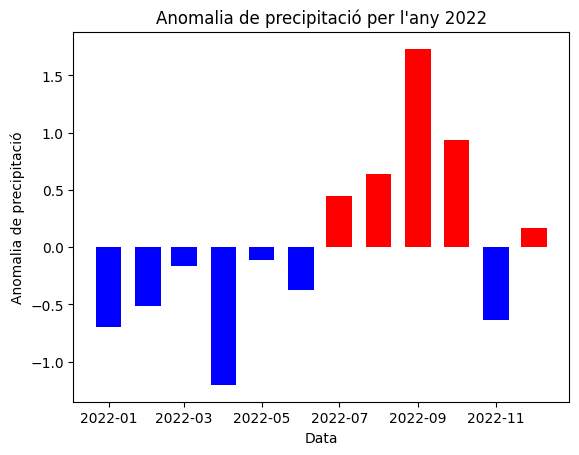

In [15]:
# Visualize temperature anomaly on a graph

import matplotlib.pyplot as plt

# Red are positive anomaly values while blue are negative

colors = ['blue' if val < 0 else 'red' for val in df_merged['anomalia']]

plt.bar(df_merged["date"], df_merged["anomalia"],  color=colors, width=20)

plt.xlabel("Data")
plt.ylabel("Anomalia de precipitació")
plt.title("Anomalia de precipitació per l'any " + str(year))
plt.show()

##**Calculating monthly precipitation anomaly for a range of years**

In [21]:
# Define timerange

start_year_analysis = 2017
end_year_analysis = 2025

# Creates a list to store the DataFreame for each year

df_anomaly_list = []

for year in range(start_year_analysis, end_year_analysis + 1):
    start_date_analysis = str(year) + "-01-01"
    end_date_analysis = str(year) + "-12-31"

    dataset_analysis = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR") \
        .filterBounds(punt) \
        .filterDate(start_date_analysis, end_date_analysis) \
        .select("total_precipitation_sum")

    precip_features_analysis = dataset_analysis.map(get_precipitation).getInfo()

    data_list_analysis = [feat["properties"] for feat in precip_features_analysis["features"]]
    df_analysis = pd.DataFrame(data_list_analysis)
    df_analysis["date"] = pd.to_datetime(df_analysis["date"])
    df_analysis["month"] = df_analysis["date"].dt.month

    df_merged = pd.merge(df_analysis, stats, on="month", how="left")
    df_merged["anomaly"] = (df_merged["precipitation"] - df_merged["mean"]) / df_merged["std"]

    # Adding the DataFrame to the list

    df_anomaly_list.append(df_merged)

df_anomalies = pd.concat(df_anomaly_list)

# Show results

print(df_anomalies)



         date  precipitation  month        mean         std   anomaly
0  2017-01-01     503.076425      1  330.545306   90.315616  1.910313
1  2017-02-01     246.670035      2  273.717255  109.899225 -0.246109
2  2017-03-01     232.983010      3  307.831314   87.401590 -0.856372
3  2017-04-01     253.919930      4  312.148217   89.682100 -0.649274
4  2017-05-01     291.876563      5  263.362178   96.531307  0.295390
..        ...            ...    ...         ...         ...       ...
0  2025-01-01     383.028501      1  330.545306   90.315616  0.581109
1  2025-02-01     286.384838      2  273.717255  109.899225  0.115265
2  2025-03-01     301.784601      3  307.831314   87.401590 -0.069183
3  2025-04-01     181.922315      4  312.148217   89.682100 -1.452084
4  2025-05-01     307.202822      5  263.362178   96.531307  0.454160

[101 rows x 6 columns]


##**Creating the final plot with all info gathered**

Anomaly and precipitation values are added

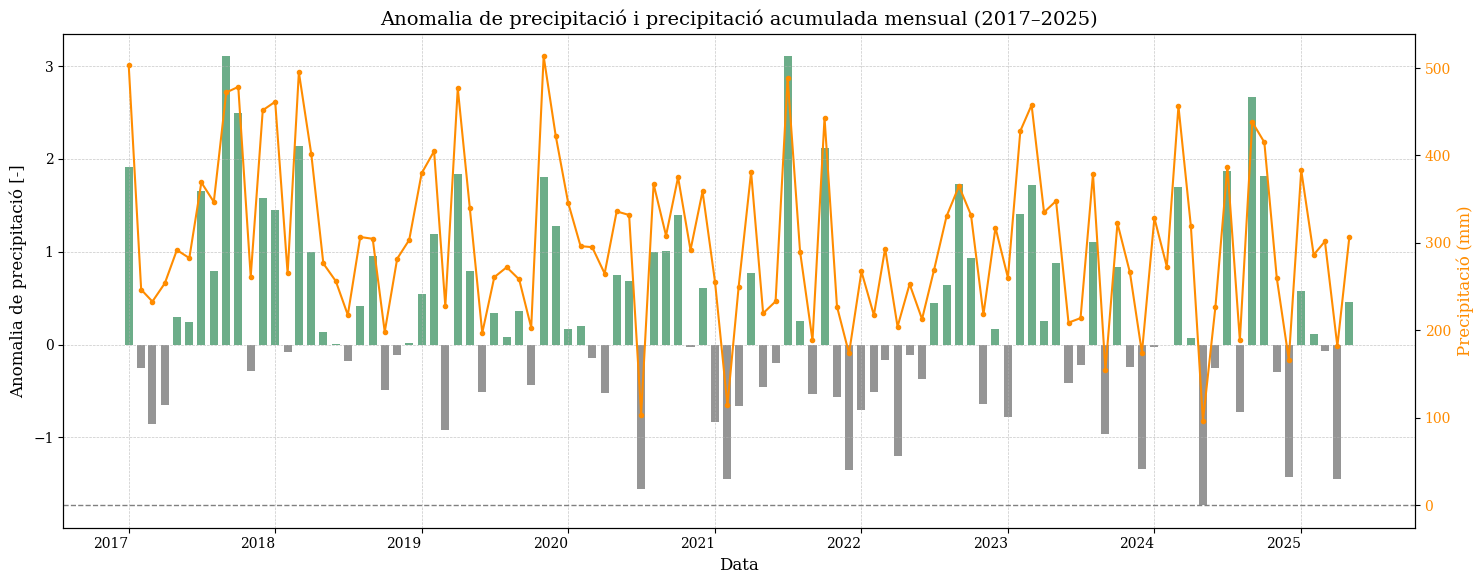

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set global style

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Create figure and axes

fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot precipitation anomaly (bars)

colors = ['dimgray' if val < 0 else 'seagreen' for val in df_anomalies['anomaly']]
bars = ax1.bar(df_anomalies["date"], df_anomalies["anomaly"], color=colors, width=20, alpha=0.7)
ax1.set_xlabel("Data")
ax1.set_ylabel("Anomalia de precipitació [-]", color="black")
ax1.tick_params(axis='y', labelcolor='black')

# Grid for primary axis

ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Plot precipitation (line) on second y-axis

ax2 = ax1.twinx()
ax2.plot(df_anomalies["date"], df_anomalies["precipitation"], color="darkorange", linestyle='-', marker='.')
ax2.set_ylabel("Precipitació (mm)", color="darkorange")
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)

# Format x-axis to show only years

ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate(rotation=0)

# Title

plt.title(f"Anomalia de precipitació i precipitació acumulada mensual ({start_year_analysis}–{end_year_analysis})")
plt.tight_layout()
plt.show()
